# Aplicaciones de la simulación

Dada una secuencia de 6 números enteros y un séptimo valor (también entero) como objetivo, el problema consiste en obtener una secuencia de operadores aritméticos (+, −, ×, /) que, respetando el orden de los 6 valores dados, nos permita aproximarnos lo más posible al valor objetivo. Por ejemplo, dados los números: 25, 6, 9, 75, 50 y 3, las siguientes secuencias de operadores se interpretan como
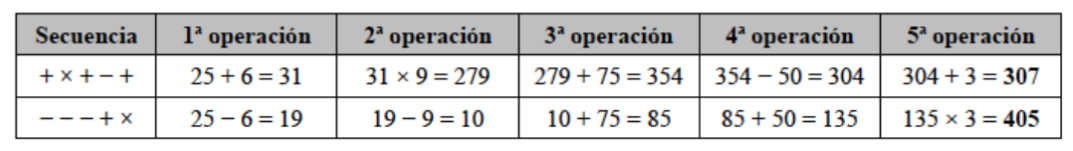

Si nuestro valor objetivo fuera el 307, la primera de las secuencias sería mejor solución que la segunda; de hecho, sería una solución óptima ya que se trata de la máxima aproximación posible. Dados los números 75, 3, 1, 4, 50, 6, 12, 8 obtener la secuencia de operadores que más aproximen el resultado de las operaciones correspondientes al valor 852.

In [472]:
import random
import numpy as np

current_seed = random.randint(0, 1000000)
random.seed(119160)
np.random.seed(119160)
print(f"Current random seed: {119160}")

Current random seed: 119160


In [473]:
import random
from random import randint
import numpy as np

def generar_poblacion(tam_poblacion):
    """
    Genera una población inicial de individuos 
    INPUT: tam_poblacion (int): Número de individuos en la población
    OUTPUT: Lista de listas donde cada sublista representa un individuo
    """   
    # Inicializamos la población
    poblacion = []
    
    # Generamos cada individuo
    for _ in range(tam_poblacion):
        # Creamos un individuo aleatorio con índices que representan operadores ('+', '-', '*', '/')
        individuo = [randint(0, len(operadores)-1) for _ in range(len(lista_numeros) - 1)]
        poblacion.append(individuo)
        
    return poblacion

In [474]:
def evaluar_individuo(operadores):
    """
    Aplica los operadores codificados por el individuo a la lista de numeros
    INPUT: operadores ([int]): Un individuo (Vector de operadores codificados del 0 al 3) .
    OUTPUT: Evaluacion del individuo
    
    (Devuelve None si hay una división por cero o resultado no válido.)
    """
    # Creamos un diccionario que mapea los operadores a sus funciones
    aplicar_operador = {
        0: lambda x, y: x + y,
        1: lambda x, y: x - y,
        2: lambda x, y: x * y,
        3: lambda x, y: x / y 
    }

    result = lista_numeros[0]
    for i, op in enumerate(operadores):
        try:
            result = aplicar_operador[op](result, lista_numeros[i + 1])
            if isinstance(result, complex) or result == float('inf'):
                return 10E9
        except ZeroDivisionError:
            return 10E9
    return abs(objetivo-result)

In [475]:
def evaluar_poblacion(poblacion):
    """
    Evalua una población dada 
    INPUT: poblacion ([[int]]): Vector de individuos.
    OUTPUT: Evaluaciones de cada individuo
    """ 
    # Inicializo vector de puntuaciones
    evaluaciones = []

    for i in poblacion:
        evaluaciones.append(evaluar_individuo(i))

    return evaluaciones

In [476]:
def individuo_to_string(ind):
    """
    Función para imprimir individuos
    """
    str = ""
    for _ in ind:
        str += "("
    for i in range(len(ind)+len(lista_numeros)):
        if i % 2 == 0:
            if i == 0:
                str += f"{lista_numeros[i//2]}"
            else:
                str += f"{lista_numeros[i//2]})"
        else:
            if ind[(i-1)//2] == 0:
                str += " + "
            elif ind[(i-1)//2] == 1:
                str += " - "
            elif ind[(i-1)//2] == 2:
                str += " * "
            elif ind[(i-1)//2] == 3:
                str += " / "
    
    return str + f" = {evaluar_individuo(ind):.0f}"


def print_poblacion(poblacion):
    """
    Función para imprimir poblaciones
    """
    evals = evaluar_poblacion(poblacion)
    mejor = evals.index(min(evals))
    print(f"Mejor Individuo [{mejor+1}] : {individuo_to_string(poblacion[mejor])}, score: {evals[mejor]:.2f}")
    print("=" * 100)
    for i in range(len(poblacion)):
        print(f"Individuo {i+1}: {poblacion[i]},    score: {objetivo} - {evaluar_individuo(poblacion[i]):.2f} = {evals[i]:.2f}")
    return

### Operadores (seleccion (prob y torneo), cruce y mutacion)

In [477]:
def seleccion_torneo(poblacion, k_torneo, num_seleccionados):
    """
    Realiza selección por torneo.
    
    INPUT:
    - poblacion: lista de individuos.
    - evaluaciones: lista de fitness o score.
    - k_torneo: tamaño del grupo de torneo.
    - num_seleccionados: número de individuos a seleccionar.
    
    OUTPUT:
    - lista de individuos seleccionados.
    """
    seleccionados = []
    evaluaciones = evaluar_poblacion(poblacion)
    
    for _ in range(num_seleccionados):
        # Selecciona k_torneo individuos al azar de la población.
        indices_torneo = random.sample(range(len(poblacion)), k_torneo)
        participantes = [poblacion[i] for i in indices_torneo]
        evaluar_torneo = [evaluaciones[i] for i in indices_torneo]
        
        # Seleccionar al mejor del torneo
        ganador = participantes[evaluar_torneo.index(min(evaluar_torneo))]
        # print(f'el ganador de la seleccion es {evaluar_individuo(ganador)} de entre {evaluar_poblacion(participantes)}')
        seleccionados.append(ganador)
        
    return seleccionados

In [ ]:
pob_prueba = generar_poblacion(10)
seleccion_torneo(pob_prueba, 5, 10)
print(pob_prueba)
evaluar_poblacion(pob_prueba)

[596.0, 1340.0, 850.0, 96, 90156, 29724.0, 834.12, 849.92, 112.0, 841.3125]

In [479]:
def cruce_un_punto(padre1, padre2, prob_cruce=0.8):
    """
    Realiza un cruce de un punto entre dos individuos con una cierta probabilidad.
    INPUT:
    - padre1: primer individuo (lista de genes).
    - padre2: segundo individuo (lista de genes).
    - prob_cruce: probabilidad de realizar el cruce.
    OUTPUT:
    - hijo1, hijo2: nuevos individuos resultantes del cruce.
    """
    if random.random() < prob_cruce:
        punto_cruce = random.randint(1, len(padre1) - 1)
        hijo1 = padre1[:punto_cruce] + padre2[punto_cruce:]
        hijo2 = padre2[:punto_cruce] + padre1[punto_cruce:]
    else:
        # Si no hay cruce, los hijos son copias de los padres
        hijo1, hijo2 = padre1.copy(), padre2.copy()
    
    return hijo1, hijo2

In [480]:
def mutar(individuo, operadores, prob_mutacion=0.1):
    """
    Realiza una mutación aleatoria en un individuo con una cierta probabilidad.
    INPUT:
    - individuo: lista de genes.
    - operadores: rango de valores posibles para los genes.
    - prob_mutacion: probabilidad de mutar cada gen.
    OUTPUT:
    - individuo mutado.
    """
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:  # Mutación basada en probabilidad
            individuo[i] = random.choice([0, 1, 2, 3])
    return individuo

In [481]:
def seleccion_probabilistica(poblacion, evaluaciones, num_seleccionados):
    """
    Selecciona individuos de la población de forma probabilística basada en su fitness.
    INPUT:
    - poblacion: lista de individuos.
    - evaluaciones: lista de fitness de los individuos (menor es mejor).
    - num_seleccionados: número de individuos a seleccionar.
    OUTPUT:
    - seleccionados: lista de individuos seleccionados.
    """
    # Invertir las evaluaciones para que los valores más bajos tengan mayor probabilidad
    fitness_inverso = [1 / (1 + eval) for eval in evaluaciones]
    
    # Normalizar las probabilidades
    suma_fitness = sum(fitness_inverso)
    probabilidades = [fit / suma_fitness for fit in fitness_inverso]
    
    # Seleccionar individuos
    seleccionados = random.choices(poblacion, weights=probabilidades, k=num_seleccionados)
    return seleccionados

# Genetic Main

In [482]:
def genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=True):

    # Defino listas para las representaciones
    best_fitness_history = []
    average_fitness_history = [] 
    # CASO DE ERROR
    if (len(lista_numeros) < 2):
        print("Error: La lista debe tener al menos dos números.")
        return -1
    
    # Crear de población inicial
    poblacion = generar_poblacion(n_inicial)
    mejor_score = float('inf')
    mejor_solucion = None

    for _ in range (n_epocas):
        # Evaluamos la poblacion actual
        evaluaciones = evaluar_poblacion(poblacion)
        
        #registrar la mejor solucion hasta el momento
        min_score = min(evaluaciones)
        if min_score < mejor_score:
            mejor_score = min_score
            mejor_solucion = poblacion[evaluaciones.index(min_score)].copy()
        
        best_fitness_history.append(mejor_score)
        average_fitness_history.append(np.mean(evaluaciones))
        
        # Criterio de parada
        if mejor_score == 0:
            break
        
        # Seleccionamos padres y generamos siguiente población
        padres = seleccion_torneo(poblacion, k_torneo = k_torneo, num_seleccionados = n_inicial)
        # padres = seleccion_probabilistica(poblacion, evaluaciones, num_seleccionados=n_inicial)
        nueva_poblacion = []
        tamaño_poblacion = n_inicial

        # Aplicar cruce y generar nueva población
        for i in range(0, len(padres), 2):
            if i + 1 < len(padres):  # Asegurar que hay suficientes padres para cruzar
                padre1, padre2 = padres[i], padres[i + 1]
                hijo1, hijo2 = cruce_un_punto(padre1, padre2, prob_cruce=prob_cruce)
                nueva_poblacion.extend([hijo1, hijo2])
            else:
                print('no hay pareja')
                nueva_poblacion.append(padres[i])  # Si no hay pareja, el individuo sobrevive
                
            # Aplicar mutación a la nueva población
            nueva_poblacion = [mutar(individuo, operadores, prob_mutacion=prob_mutacion) for individuo in nueva_poblacion]
            poblacion = nueva_poblacion
                
                
                
    
    #imprimo solo la última población
    if see_last_pop: print_poblacion(poblacion)
    
    return mejor_solucion, mejor_score, best_fitness_history, average_fitness_history

In [483]:
# Definición del problema: (Valores default)
lista_numeros = [ 75, 3, 1, 4, 50, 6, 12, 8] # ejemplo: [25, 6, 9, 75, 50, 3, 8]
objetivo = 852 # ejemplo: 307
operadores = ['+', '-', '*', '/']

In [484]:
n_inicial = 30
n_epocas = 100
k_torneo = 3
prob_cruce = 0.6
prob_mutacion = 0.05

mejor, _, best_fitness_history, average_fitness_history = genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, 
                                                                   n_epocas, prob_cruce, prob_mutacion)
print("=" * 100)
print(f"{individuo_to_string(mejor)}, score: {evaluar_individuo(mejor)}")

Mejor Individuo [26] : (((((((75 - 3) / 1) + 4) / 50) * 6) * 12) * 8) = 24, score: 23.52
Individuo 1: [2, 3, 0, 3, 1, 1, 1],    score: 852 - 873.42 = 873.42
Individuo 2: [0, 0, 3, 2, 2, 3, 1],    score: 852 - 366.25 = 366.25
Individuo 3: [0, 0, 0, 3, 2, 3, 2],    score: 852 - 845.36 = 845.36
Individuo 4: [2, 1, 3, 1, 2, 2, 0],    score: 852 - 412.00 = 412.00
Individuo 5: [2, 0, 3, 3, 2, 2, 2],    score: 852 - 201.12 = 201.12
Individuo 6: [0, 0, 0, 3, 3, 1, 1],    score: 852 - 871.72 = 871.72
Individuo 7: [2, 3, 3, 2, 3, 2, 2],    score: 852 - 44148.00 = 44148.00
Individuo 8: [2, 2, 3, 3, 2, 2, 2],    score: 852 - 204.00 = 204.00
Individuo 9: [0, 0, 0, 0, 3, 3, 2],    score: 852 - 837.22 = 837.22
Individuo 10: [2, 2, 2, 3, 0, 2, 2],    score: 852 - 1452.00 = 1452.00
Individuo 11: [1, 3, 1, 3, 3, 0, 1],    score: 852 - 847.77 = 847.77
Individuo 12: [2, 0, 0, 1, 2, 2, 2],    score: 852 - 102828.00 = 102828.00
Individuo 13: [0, 2, 2, 1, 1, 2, 0],    score: 852 - 2228.00 = 2228.00
Individuo

# Testing

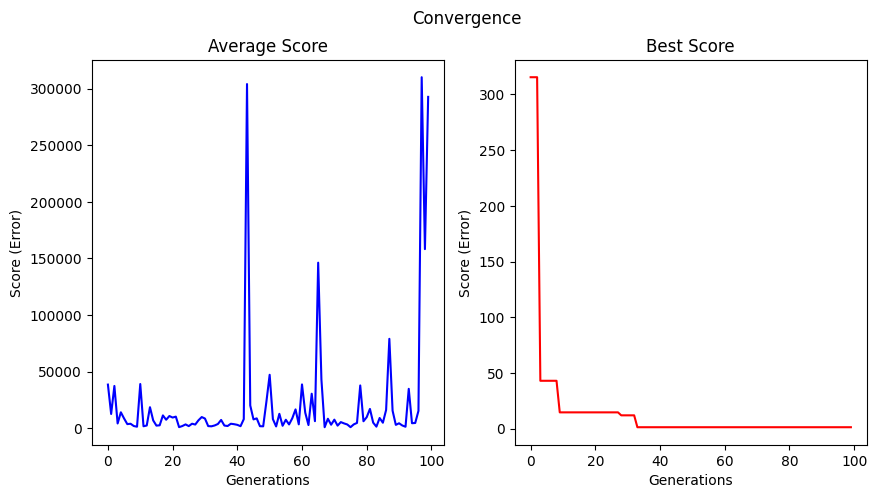

In [485]:
import matplotlib.pyplot as plt

generations_range = range(len(best_fitness_history))  # Rango de generaciones en el historial
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Error promedio
axs[0].plot(generations_range, average_fitness_history, color="blue")
axs[0].set_title("Average Score")
axs[0].set_xlabel("Generations")
axs[0].set_ylabel("Score (Error)")


# Error máximo (mejor fitness)
axs[1].plot(generations_range, best_fitness_history, color="red")
axs[1].set_title("Best Score")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("Score (Error)")

plt.suptitle(f"Convergence")
plt.show()

ANALISIS DE RESULTADOS

In [486]:
def poblacion_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for n_inicial in population_sizes:
        
        # Ejecutar el solver y obtener los historiales de fitness
        _, _, best_fitness_history, average_fitness_history = genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

        # Rango de generaciones en el historial
        generations_range = range(len(best_fitness_history))

        # Gráfico del "Average Score" para cada tamaño de población
        axs[0].plot(generations_range, average_fitness_history, label=f"Pop Size: {k_torneo}")
        axs[0].set_title("Average Score")
        axs[0].set_xlabel("Generations")
        axs[0].set_ylabel("Score")

        # Gráfico del "Max Score" (mejor fitness) para cada tamaño de población
        axs[1].plot(generations_range, best_fitness_history, label=f"Pop Size: {k_torneo}")
        axs[1].set_title("Max Score")
        axs[1].set_xlabel("Generations")
        axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Population Size on Fitness Convergence\n\nCROSSOVER_RATE={prob_cruce}, MUTATION_RATE={prob_mutacion}")
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tamaños de población para evaluar
population_sizes = [50, 100, 200, 300]  # Diferentes tamaños de población inicial

# Ejecutar los experimentos
# poblacion_experiments()

In [487]:
def run_crossover_mutation_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for prob_cruce in crossover_rates:
        for prob_mutacion in mutation_rates:

            # Ejecutar el solver y obtener los historiales de fitness
            _, _, best_fitness_history, average_fitness_history = genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

            # Rango de generaciones en el historial
            generations_range = range(len(best_fitness_history))

            # Gráfico del "Average Score" para cada combinación de cruce y mutación
            label = f"Crossover: {prob_cruce}, Mutation: {prob_mutacion}"
            axs[0].plot(generations_range, average_fitness_history, label=label)
            axs[0].set_title("Average Score", pad=20)
            axs[0].set_xlabel("Generations")
            axs[0].set_ylabel("Score")

            # Gráfico del "Max Score" (mejor fitness) para cada combinación de cruce y mutación
            axs[1].plot(generations_range, best_fitness_history, label=label)
            axs[1].set_title("Max Score", pad=20)
            axs[1].set_xlabel("Generations")
            axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Crossover and Mutation Rates on Fitness Convergence\nPopulation Size=100")
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tasas de cruce y mutación para evaluar
crossover_rates = [0.3, 0.7, 0.9]   # Diferentes tasas de cruce
mutation_rates = [0.05, 0.1, 0.2]   # Diferentes tasas de mutación

n_inicial = 50
n_epocas = 100
k_torneo = 3

# Ejecutar los experimentos
# run_crossover_mutation_experiments()

In [488]:
def run_tournament_experiments():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    for k_torneo in tournament_sizes:
        
        # Ejecutar el solver y obtener los historiales de fitness
        _, _, best_fitness_history, average_fitness_history = genetic_main(lista_numeros, objetivo, operadores, n_inicial, k_torneo, n_epocas, prob_cruce, prob_mutacion, see_last_pop=False)

        # Rango de generaciones en el historial
        generations_range = range(len(best_fitness_history))

        # Gráfico del "Average Score" para cada tamaño de torneo
        label = f"Tournament Size: {k_torneo}"
        axs[0].plot(generations_range, average_fitness_history, label=label)
        axs[0].set_title("Average Score")
        axs[0].set_xlabel("Generations")
        axs[0].set_ylabel("Score")

        # Gráfico del "Max Score" (mejor fitness) para cada tamaño de torneo
        axs[1].plot(generations_range, best_fitness_history, label=label)
        axs[1].set_title("Max Score")
        axs[1].set_xlabel("Generations")
        axs[1].set_ylabel("Score")

    # Ajustes finales de título y leyenda
    plt.suptitle(f"Effect of Tournament Size on Fitness Convergence\nPopulation Size={n_inicial}", y=1.05)
    axs[0].legend(loc="upper right")
    axs[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Configuración de tamaños de torneo para evaluar
tournament_sizes = [2, 3, 5, 7]   # Diferentes tamaños de torneo para evaluación
n_inicial = 30
n_epocas = 100
prob_cruce = 0.8
prob_mutacion = 0.1              

# Ejecutar los experimentos
# run_tournament_experiments()